# Scaling Scanpy on Spark
This notebook explores the scaling characteristics of running Scanpy on Spark.

The data was gathered using the `benchmark_recipe_spark.py` script. This runs the Zheng17 preprocessing recipe on a Google Dataproc Spark cluster.

First, let's import the result data and have a look at it. The independent variables are the number of worker cores, and the number of rows in the input dataset. (The number of columns in the data, 27998, was constant.) The dependent variable is the job duration, measured in seconds.

In [1]:
import pandas as pd

results = pd.read_csv('results/results-all.csv')

In [2]:
results

,worker_cores,input_row_count,input_path,output_path,success,duration
0,2,10000,ll-sc-data-bkup/10x/anndata_zarr/10x_10000.zarr,ll-sc-data-bkup/10x/anndata_zarr_out/run=20181...,True,133.285292
1,2,100000,ll-sc-data-bkup/10x/anndata_zarr/10x_100000.zarr,ll-sc-data-bkup/10x/anndata_zarr_out/run=20181...,True,930.083222
2,8,10000,ll-sc-data-bkup/10x/anndata_zarr/10x_10000.zarr,ll-sc-data-bkup/10x/anndata_zarr_out/run=20181...,True,112.353805
3,8,100000,ll-sc-data-bkup/10x/anndata_zarr/10x_100000.zarr,ll-sc-data-bkup/10x/anndata_zarr_out/run=20181...,True,270.185556
4,8,1000000,ll-sc-data-bkup/10x/anndata_zarr/10x_1000000.zarr,ll-sc-data-bkup/10x/anndata_zarr_out/run=20181...,True,2309.919094
5,32,10000,ll-sc-data-bkup/10x/anndata_zarr/10x_10000.zarr,ll-sc-data-bkup/10x/anndata_zarr_out/run=20181...,True,121.593417
6,32,100000,ll-sc-data-bkup/10x/anndata_zarr/10x_100000.zarr,ll-sc-data-bkup/10x/anndata_zarr_out/run=20181...,True,125.151370
7,32,1000000,ll-sc-data-bkup/10x/anndata_zarr/10x_1000000.zarr,ll-sc-data-bkup/10x/anndata_zarr_out/run=20181...,True,689.956953
8,128,10000,ll-sc-data-bkup/10x/anndata_zarr/10x_10000.zarr,ll-sc-data-bkup/10x/anndata_zarr_out/run=20181...,True,112.848266
9,128,100000,ll-sc-data-bkup/10x/anndata_zarr/10x_100000.zarr,ll-sc-data-bkup/10x/anndata_zarr_out/run=20181...,True,119.945527


To see the effect of using more cores, plot the number of cores against job duration.

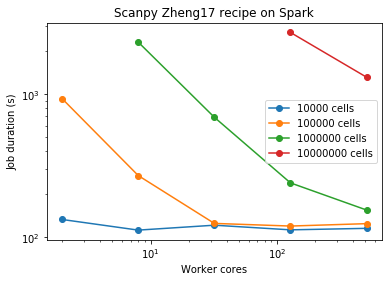

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

for rows in [10000, 100000, 1000000, 10000000]:
    results_subset = results[results['input_row_count'] == rows][['worker_cores','duration']]
    plt.loglog('worker_cores', 'duration', data=results_subset, marker='o', label='{} cells'.format(rows))
    
plt.title("Scanpy Zheng17 recipe on Spark")
plt.xlabel('Worker cores')
plt.ylabel('Job duration (s)')
plt.legend()

For the small dataset (10<sup>4</sup> cells) the duration is constant, which means that running on a cluster has no benefit. For lager datasets we see that increasing the number of cores reduces the runtime.

To understand the speedup, we compare against running on a single core (that is, not using Spark). This was done using 10<sup>6</sup> cells, so we extrapolate assuming it scales linearly.

In [4]:
single_core_duration_10e6 = 4213 # measured manually
results['speedup'] = (single_core_duration_10e6 / 1000000) * results['input_row_count'] / results['duration']

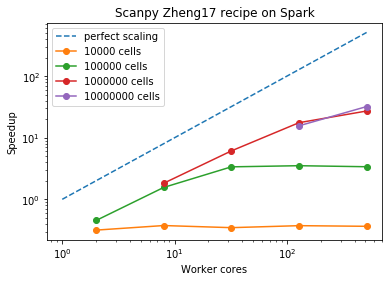

In [5]:
plt.loglog([1, 512], [1, 512], '--', label='perfect scaling')
for rows in [10000, 100000, 1000000, 10000000]:
    results_subset = results[results['input_row_count'] == rows][['worker_cores','speedup']]
    plt.loglog('worker_cores', 'speedup', data=results_subset, marker='o', label='{} cells'.format(rows))

plt.title("Scanpy Zheng17 recipe on Spark")
plt.xlabel('Worker cores')
plt.ylabel('Speedup')
plt.legend()

Again, for small numbers of cells there is little if any benefit to running on a larger cluster. However, we see that for larger cell counts the scaling is effective - up to a point, since we see that the curves level off at the point where adding more nodes to the cluster is not effective.

Finally, let's look at how the job duration varies with cell count. 

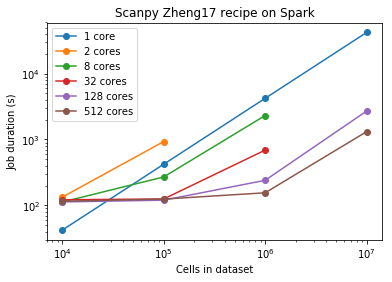

In [6]:
single_core_runtimes = pd.DataFrame([[1000000 * pow(10, i), single_core_duration_10e6 * pow(10, i)] for i in range(-2, 2)], columns=['input_row_count', 'duration'])
plt.loglog('input_row_count', 'duration', data=single_core_runtimes, marker='o', label='1 core')

for worker_cores in [2, 8, 32, 128, 512]:
    results_subset = results[results['worker_cores'] == worker_cores][['input_row_count','duration']]
    plt.loglog('input_row_count', 'duration', data=results_subset, marker='o', label='{} cores'.format(worker_cores))

plt.title("Scanpy Zheng17 recipe on Spark")
plt.xlabel('Cells in dataset')
plt.ylabel('Job duration (s)')
plt.legend()

Small clusters (e.g. 2 nodes) are actually slower than running without Spark. This is not surprising since any distributed computation has some overhead, usually in communication between cores, so you need a few cores before the computation gets more efficient than the single core case.

For large datasets, we see that using a cluster scales well (the curves are roughly parallel to the single core case), and also dramatically outperform the single core case.